In [20]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import numpy as np #numerical python used for working with arrays, mathematical operations
import time #useful for timing functions
import sys
import glob #glob is helpful for searching for filenames or directories
import scipy #scientific python
import pickle #for saving data
from pathlib import Path
import skimage
from skimage import io
from importlib import reload
from itertools import chain, groupby
from skimage.filters import threshold_otsu, threshold_local
from skimage.transform import downscale_local_mean

import openpyxl #can be installed with 'conda install -c anaconda openpyxl'

### Defining the functions used

In [60]:
def run_length(iterable):
    '''
    Finds the lengths of runs of zeros.
    '''
    zero_runs = []
    for val, thing in groupby(iterable):
        if val==0:
            zero_runs.append(len(list(thing)))
    return zero_runs


def process_image(im, downscale=(3,2,2), median_blur_size=19):
    '''
    This function filters and processes the raw image data. 
    We first downscale the image. The default is to downscale the 
      three dimensions by 3,2,2. 
    Next, a median is calculated and filtered with a Gaussian filter
      with blur size given by parameter 'median_blur_size'.
    We then return the original image stack with the background
      subtracted off.
    
    '''
    new_im = downscale_local_mean(im, downscale)
    im_median = np.median(new_im,axis=0)
    im_median_blur = skimage.filters.gaussian(im_median, median_blur_size)
    return new_im-im_median_blur


def run_length_all_images(ims, block_size=35, offset_for_threshold=10, gaussian_filter_size = None,
                         save_images_for_debugging = False, dataset_title=' ', dir_to_save=None):
    '''
    Goes through all images in a stack and finds the run lengths.
    
    '''
    num_frames,vertical_pixels,horizontal_pixels = ims.shape #finds dimensions of image stack
    
    #initialize list to store vertical and horizontal run lengths
    all_runs_vertical = []
    all_runs_horizontal = []
    
    #loop over all frames in the image stack
    for i in range(num_frames):
        if gaussian_filter_size is not None:
            new_im = skimage.filters.gaussian(ims[i], gaussian_filter_size)
        else:
            new_im = ims[i]
            
        #find and apply threshold to generate binary image
        local_thresh = threshold_local(new_im, block_size, offset=offset_for_threshold)
        binary_image = new_im > local_thresh
        
        #saves an image along with the binary image (for checking that everything works)
        if save_images_for_debugging and i==0:
            fig, axs = plt.subplots(1, 2, figsize=(7, 4), constrained_layout=True)
            fig.suptitle(dataset_title)
            axs[0].matshow(new_im, cmap='gray')
            axs[0].set_title("image")
            axs[1].matshow(binary_image, cmap='gray')
            axs[1].set_title("binary image")
            if dir_to_save is not None:
                plt.savefig(dir_to_save + "debug_%s_image.png" % dataset_title, dpi=300)
            plt.close()
            
        #loops over all horizontal rows
        for j in range(horizontal_pixels):
            all_runs_vertical.append(run_length(binary_image[:,j]))
            
        #loops over all vertical columns
        for k in range(vertical_pixels):
            all_runs_horizontal.append(run_length(binary_image[k,:]))
            
    #returns two lists: run lengths in vertical direction and run lengths in horizontal direction
    return (list(chain(*all_runs_vertical)), list(chain(*all_runs_horizontal)))


#To be used later when connecting data to TRIOS rheology/temperature data
def temperature_at_nearest_steptime(steptime, trios_temps, trios_steptimes):
    '''
    Finds the temperature corresponding to some steptime
    
    Paramters
    ---------
    
    steptime: float
        Value of step time for which you want the temperature
        
    trios_temps: ndarry
        Array of temperatures (should be from the TRIOS data)
        
    trios_steptimes: ndarray
        Array of step times corresponding to temperatures (again, from TRIOS)
    
    '''
    difference_of_times = abs(trios_steptimes - steptime)
    arg_minimum = np.argmin(difference_of_times)
    return trios_temps[arg_minimum]

### Starting the analysis
We start by specifying what data to analyze

In [5]:
#Specify where the data is stored 
data_dir = "Y:\\Dennis Terwilliger\\Data\\2021-06-08\\02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x\\"

#list of movie numbers
movie_nums = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

#lists of subdirectories and filenames
list_of_subdirs = ['02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x_%i\\' % num for num in movie_nums]
list_of_filenames = ['02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x_%i_MMStack_Default.ome.tif' % num for num in movie_nums]

#Creating a dictionary (type of data structure in python) to save all data
all_data_dictionary = {}
all_data_dictionary['data_dir'] = data_dir

In [6]:
block_size = 71
offset_for_threshold = 0.01
gaussian_filter_size = 1
downscale_size = (3,2,2)
median_blur_size = 19
every_this_many_frames = 20
bins = np.linspace(1,328,80)

all_data_dictionary['block_size'] = block_size
all_data_dictionary['offset_for_threshold'] = offset_for_threshold
all_data_dictionary['gaussian_filter_size'] = gaussian_filter_size
all_data_dictionary['median_blur_size'] = median_blur_size
all_data_dictionary['every_this_many_frames'] = every_this_many_frames
all_data_dictionary['bins'] = bins
all_data_dictionary['list_of_subdirs'] = [] #Creating empty list to be filled in for loop below
all_data_dictionary['movie_nums'] = [] #Creating empty list to be filled in for loop below

plt.ioff()
for i,fn in enumerate(list_of_filenames):
    try:
        my_file = Path(data_dir+list_of_subdirs[i]+fn)
        if not my_file.is_file():
            print("%s does not exist." % fn)
        im = skimage.io.imread(data_dir+list_of_subdirs[i]+fn)
        all_data_dictionary['list_of_subdirs'].append(list_of_subdirs[i])
        all_data_dictionary['movie_nums'].append(movie_nums[i])
        new_im = process_image(im,downscale=downscale_size, median_blur_size=median_blur_size)
        av,ah = run_length_all_images(new_im[::every_this_many_frames], block_size=block_size, 
                                      offset_for_threshold=offset_for_threshold, gaussian_filter_size=gaussian_filter_size,
                                      save_images_for_debugging=True, dataset_title=fn, dir_to_save=data_dir+list_of_subdirs[i])
        all_data_dictionary['av_%i' % movie_nums[i]] = av
        all_data_dictionary['ah_%i' % movie_nums[i]] = ah
        n_vert,b = np.histogram(av, bins=bins)
        n_hori,b = np.histogram(ah, bins=bins)
        all_data_dictionary['nv_%i' % movie_nums[i]] = n_vert
        all_data_dictionary['nh_%i' % movie_nums[i]] = n_hori
    except:
        print("Unable to open %s" % data_dir+list_of_subdirs[i]+fn)
    

02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x_14_MMStack_Default.ome.tif does not exist.
Unable to open Y:\Dennis Terwilliger\Data\2021-06-08\02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x\02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x_14\02_temp ramp_5Hz_(23-34Deg)_(34-23Deg)2x_14_MMStack_Default.ome.tif


In [17]:
### Connect the movie number with the step time and the temperature

step_time = np.array([936,1046,1083,1146,1177,1202,1226,1251,1279,1310,1374,2135,2209,2450,2603,3039,3157,3195])
all_data_dictionary['step_time'] = step_time
    

#### We save the data
Using the [pickle](https://docs.python.org/3/library/pickle.html) function we save the data. 

In [204]:
pickle.dump(all_data_dictionary, open(data_dir+"all_data_dict.p", "wb"))

#### Generating plots

<IPython.core.display.Javascript object>


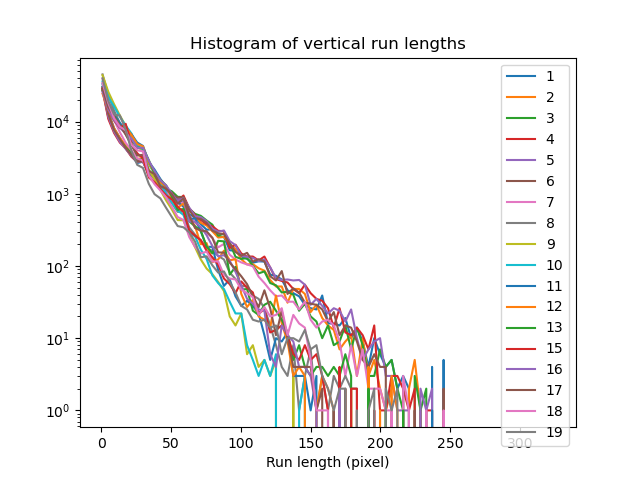

<IPython.core.display.Javascript object>


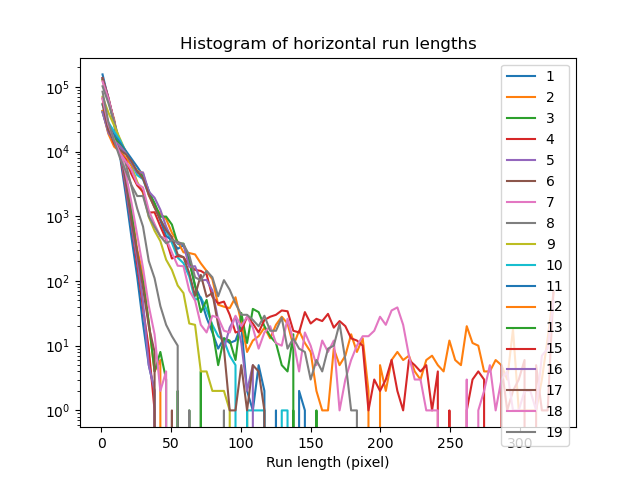

Text(0.5, 0, 'Run length (pixel)')

In [11]:
#First, plot historgrams of the run lengths

plt.ion()
plt.figure()
for i,num in enumerate(all_data_dictionary['movie_nums']):
    plt.semilogy(all_data_dictionary['bins'][:-1], all_data_dictionary['nv_%i' % num], label='%i' % num)
plt.legend(loc=0)
plt.title("Histogram of vertical run lengths")
plt.xlabel("Run length (pixel)")

plt.figure()
for i,num in enumerate(all_data_dictionary['movie_nums']):
    plt.semilogy(all_data_dictionary['bins'][:-1], all_data_dictionary['nh_%i' % num], label='%i' % num)
plt.legend(loc=0)
plt.title("Histogram of horizontal run lengths")
plt.xlabel("Run length (pixel)")

<IPython.core.display.Javascript object>


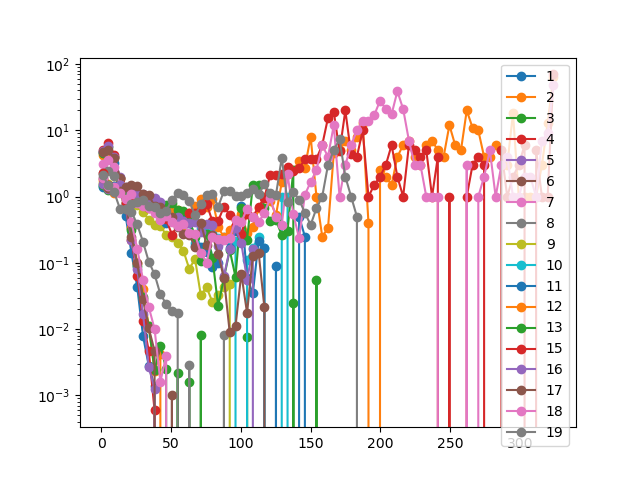

In [12]:
#Ratio of number of horizontal runs lengths over certain size to vertical run lengths of same size

plt.figure()
for i,num in enumerate(all_data_dictionary['movie_nums']):
    plt.semilogy(all_data_dictionary['bins'][:-1], all_data_dictionary['nh_%i' % num] / (1+all_data_dictionary['nv_%i' % num]), '-o', label='%i' % num)
plt.legend(loc=0)


<IPython.core.display.Javascript object>


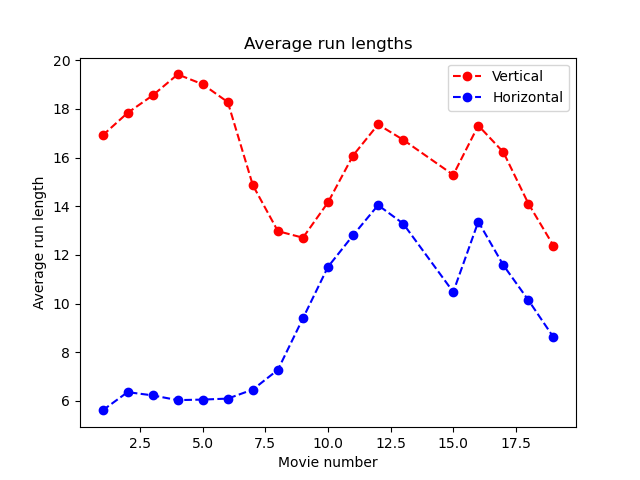

<IPython.core.display.Javascript object>


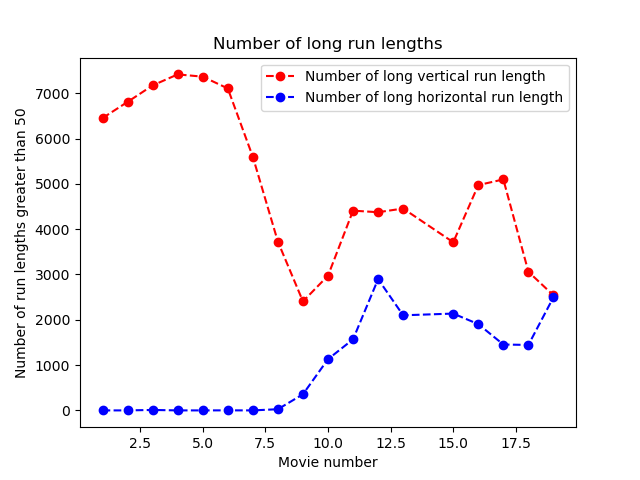

Text(0.5, 1.0, 'Number of long run lengths')

In [15]:
#Finding the mean run length
mean_av = [np.mean(all_data_dictionary['av_%i' % i]) for i in all_data_dictionary['movie_nums']]
mean_ah = [np.mean(all_data_dictionary['ah_%i' % i]) for i in all_data_dictionary['movie_nums']]
plt.figure()
plt.plot(all_data_dictionary['movie_nums'], mean_av, '--ro', label='Vertical')
plt.plot(all_data_dictionary['movie_nums'], mean_ah, '--bo', label='Horizontal')
plt.xlabel("Movie number")
plt.ylabel("Average run length")
plt.legend()
plt.title("Average run lengths")

#Finding the number of run lengths greater than some threshold value
length_threshold = 50
num_long_av = [np.sum(np.array(all_data_dictionary['av_%i' % i]) > length_threshold) for i in all_data_dictionary['movie_nums']]
num_long_ah = [np.sum(np.array(all_data_dictionary['ah_%i' % i]) > length_threshold) for i in all_data_dictionary['movie_nums']]
plt.figure()
plt.plot(all_data_dictionary['movie_nums'], num_long_av, '--ro', label='Number of long vertical run length')
plt.plot(all_data_dictionary['movie_nums'], num_long_ah, '--bo', label='Number of long horizontal run length')
plt.xlabel("Movie number")
plt.ylabel("Number of run lengths greater than %i" % length_threshold)
plt.legend()
plt.title("Number of long run lengths")

<IPython.core.display.Javascript object>


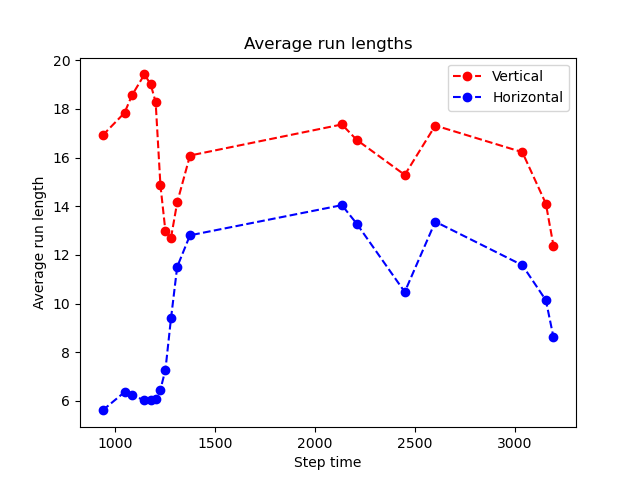

<IPython.core.display.Javascript object>


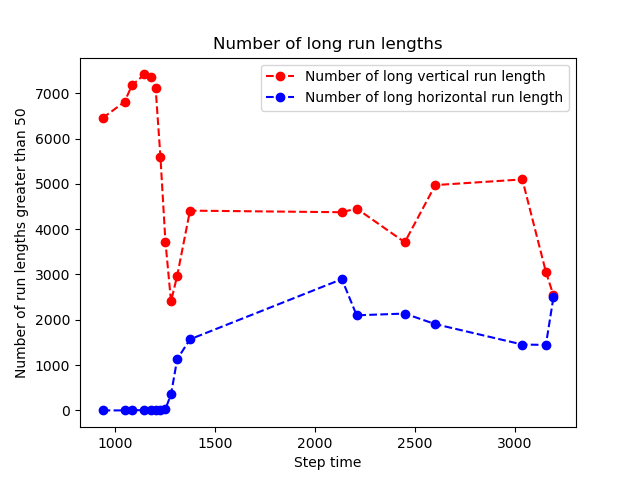

Text(0.5, 1.0, 'Number of long run lengths')

In [19]:
#Finding the mean run length
mean_av = [np.mean(all_data_dictionary['av_%i' % i]) for i in all_data_dictionary['movie_nums']]
mean_ah = [np.mean(all_data_dictionary['ah_%i' % i]) for i in all_data_dictionary['movie_nums']]
plt.figure()
plt.plot(all_data_dictionary['step_time'], mean_av, '--ro', label='Vertical')
plt.plot(all_data_dictionary['step_time'], mean_ah, '--bo', label='Horizontal')
plt.xlabel("Step time")
plt.ylabel("Average run length")
plt.legend()
plt.title("Average run lengths")

#Finding the number of run lengths greater than some threshold value
length_threshold = 50
num_long_av = [np.sum(np.array(all_data_dictionary['av_%i' % i]) > length_threshold) for i in all_data_dictionary['movie_nums']]
num_long_ah = [np.sum(np.array(all_data_dictionary['ah_%i' % i]) > length_threshold) for i in all_data_dictionary['movie_nums']]
plt.figure()
plt.plot(all_data_dictionary['step_time'], num_long_av, '--ro', label='Number of long vertical run length')
plt.plot(all_data_dictionary['step_time'], num_long_ah, '--bo', label='Number of long horizontal run length')
plt.xlabel("Step time")
plt.ylabel("Number of run lengths greater than %i" % length_threshold)
plt.legend()
plt.title("Number of long run lengths")

#### Connecting to TRIOS data

We can use [openpyxl](https://openpyxl.readthedocs.io/) to read in an Excel worksheet and access the TRIOS data.

In [22]:
trio_data_file = 'Y:\\Dennis Terwilliger\\Data\\2021-06-08\\2021-06-08 Trios data.xlsx'
wb = openpyxl.load_workbook(trio_data_file)

In [69]:
#Step times:
step_time_cells = wb['Sheet1']['Q7':'Q4738']
step_times_trios = np.zeros((len(step_time_cells)))
for i,cell in enumerate(step_time_cells):
    step_times_trios[i] = cell[0].value

#Stress:
stress_cells = wb['Sheet1']['O7':'O4738']
stress_trios = np.zeros((len(stress_cells)))
for i,cell in enumerate(stress_cells):
    stress_trios[i] = cell[0].value
    
#Viscosity:
visc_cells = wb['Sheet1']['P7':'P4738']
visc_trios = np.zeros((len(visc_cells)))
for i,cell in enumerate(visc_cells):
    visc_trios[i] = cell[0].value
    
#Temperature:
temp_cells = wb['Sheet1']['R7':'R4738']
temp_trios = np.zeros((len(temp_cells)))
for i,cell in enumerate(temp_cells):
    temp_trios[i] = cell[0].value
    
#Normal stress:
normalstress_cells = wb['Sheet1']['S7':'S4738']
normalstress_trios = np.zeros((len(normalstress_cells)))
for i,cell in enumerate(normalstress_cells):
    normalstress_trios[i] = cell[0].value
    
all_data_dictionary['step_times_trios'] = step_times_trios
all_data_dictionary['stress_trios'] = stress_trios
all_data_dictionary['visc_trios'] = visc_trios
all_data_dictionary['temp_trios'] = temp_trios
all_data_dictionary['normalstress_trios'] = normalstress_trios

    
#Finding temperature at times corresponding to each movie
temperatures_for_movies = np.zeros(len(all_data_dictionary['step_time']))
for i,step_time in enumerate(all_data_dictionary['step_time']):
    temperatures_for_movies[i] = temperature_at_nearest_steptime(step_time, temp_trios, step_times_trios)
    
all_data_dictionary['temperatures'] = temperatures_for_movies

<IPython.core.display.Javascript object>


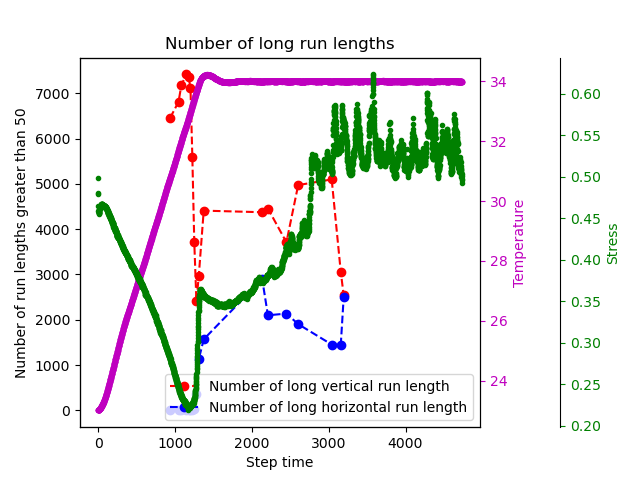

In [56]:
#Finding the number of run lengths greater than some threshold value
length_threshold = 50
num_long_av = [np.sum(np.array(all_data_dictionary['av_%i' % i]) > length_threshold) for i in all_data_dictionary['movie_nums']]
num_long_ah = [np.sum(np.array(all_data_dictionary['ah_%i' % i]) > length_threshold) for i in all_data_dictionary['movie_nums']]

#Setting up our figure for multiple y-axes (all sharing same x-axes)
fig, ax1 = plt.subplots()
fig.subplots_adjust(right=0.75)

ax1.plot(all_data_dictionary['step_time'], num_long_av, '--ro', label='Number of long vertical run length')
ax1.plot(all_data_dictionary['step_time'], num_long_ah, '--bo', label='Number of long horizontal run length')
ax1.set_xlabel("Step time")
ax1.set_ylabel("Number of run lengths greater than %i" % length_threshold)
ax1.set_title("Number of long run lengths")


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(step_times_trios, temp_trios, 'm.')
ax2.set_ylabel("Temperature")
ax2.yaxis.label.set_color('m')
ax2.tick_params(axis='y', colors='m')

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines['right'].set_position(("axes", 1.2))

ax3.plot(step_times_trios, stress_trios, 'g.')
ax3.set_ylabel("Stress")
ax3.yaxis.label.set_color('g')
ax3.tick_params(axis='y', colors='g')

ax1.legend(loc=4)

<IPython.core.display.Javascript object>


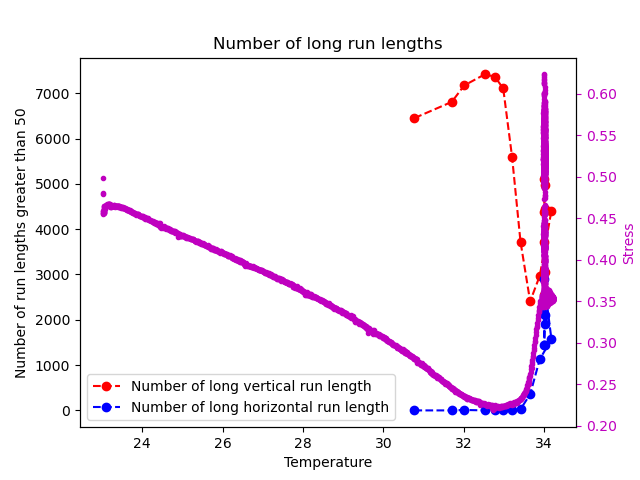

In [68]:
#Finding the number of run lengths greater than some threshold value
length_threshold = 50
num_long_av = [np.sum(np.array(all_data_dictionary['av_%i' % i]) > length_threshold) for i in all_data_dictionary['movie_nums']]
num_long_ah = [np.sum(np.array(all_data_dictionary['ah_%i' % i]) > length_threshold) for i in all_data_dictionary['movie_nums']]

#Setting up our figure for multiple y-axes (all sharing same x-axes)
fig, ax1 = plt.subplots()


ax1.plot(all_data_dictionary['temperatures'], num_long_av, '--ro', label='Number of long vertical run length')
ax1.plot(all_data_dictionary['temperatures'], num_long_ah, '--bo', label='Number of long horizontal run length')
ax1.set_xlabel("Temperature")
ax1.set_ylabel("Number of run lengths greater than %i" % length_threshold)
ax1.set_title("Number of long run lengths")


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(temp_trios, stress_trios, 'm.')
ax2.set_ylabel("Stress")
ax2.yaxis.label.set_color('m')
ax2.tick_params(axis='y', colors='m')



ax1.legend(loc=3)

In [70]:
pickle.dump(all_data_dictionary, open(data_dir+"all_data_dict.p", "wb"))